In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchtext.datasets import SST2

In [3]:
batch_size = 64
train_datapipe, dev_datapipe, test_datapipe = SST2()
# train_datapipe = SST2(split='train')

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [5]:
tokenizer = get_tokenizer(tokenizer='spacy', language='en_core_web_sm')


def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

2022-11-14 16:25:20.952973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:25:20.958116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:25:20.958342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
lengths = [len(t) for t, _ in train_datapipe]
print(f"Max length={max(lengths)}, ave length={sum(lengths)/len(lengths)}")

Max length=267, ave length=52.5055902834489


In [7]:
# text_pipeline = lambda x : vocab(tokenizer(x))
# def text_pipeline_trunc(x, max_length=64):
#     x = vocab(tokenizer(x))
#     if len(x) >= max_length:
#         return x[:max_length]
#     else:
#         return x + [vocab['<pad>'] for _ in range(max_length - len(x))]

# text_pipeline('this is a beginning work')


In [8]:
from torch.utils.data import DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:

import torchtext.functional as F

max_seq_length=128

def text_transform(x):
    x = vocab(tokenizer(x))
    x = F.truncate(x, max_seq_len=max_seq_length-2)
    x = F.add_token(x, token_id=vocab["<bos>"], begin=True)
    x = F.add_token(x, token_id=vocab["<eos>"], begin=False)
    return x


def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        # processed_text = torch.tensor(text_transform(_text), dtype=torch.long)
        processed_text = text_transform(_text)
        text_list.append(processed_text)
    # print(text_list)
    label_list = torch.tensor(label_list, dtype=torch.long)
    text_list = F.to_tensor(text_list, padding_value=vocab["<pad>"])
    return text_list, label_list

# text_transform = T.Sequential(
#     tokenizer,
#     vocab,
#     T.Truncate(max_seq_len=max_seq_length-2),
#     T.AddToken(token=vocab['<bos>'], begin=True),
#     T.AddToken(token=vocab['<eos>'], begin=False)
# )

In [10]:
train_dataloader = DataLoader(train_datapipe, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
dev_dataloader = DataLoader(dev_datapipe, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_datapipe, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [11]:
from model import BidirectionalLSTM
from tqdm.notebook import tqdm
import time
import numpy as np

In [18]:
b_model = BidirectionalLSTM(
    embedding_dim=512, lstm_hidden_dim=256, fc_hidden_dim=256, vocab=vocab, output_size=2)


In [13]:
# test loop

def test_model(model, dev_dataloader):
    b_model.eval()
    # total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    counter = 0
    with torch.no_grad():
        for text, label in dev_dataloader:
            text, label = text.to(device), label.to(device)
            output = model(text)
            predictions = output.argmax(1)

            correct_predictions += (predictions == label).sum().item()
            total_predictions += label.shape[0]
            counter += 1

    return correct_predictions / total_predictions


In [19]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.AdamW(b_model.parameters(), lr=1e-3)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
train_batch_length, train_data_length = len(list(train_dataloader)), len(list(train_dataloader.dataset))
b_model.to(device=device)
train_loss_history = []
for epoch in range(30):
    b_model.train()
    loss_history = []
    correct = 0
    bar = tqdm(total=train_batch_length)
    bar.set_description(f'Train batch {epoch}')
    for i, (text, label) in enumerate(train_dataloader):
        text, label = text.to(device), label.to(device)

        # Train step
        output = b_model(text)
        loss = loss_fn(output, label)
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        # lr_scheduler.step()


        loss_history.append(loss.item())

        # eval step
        accuracy = (output.argmax(1) == label).sum().item() 
        correct += accuracy
        accuracy /= label.shape[0]


        bar.set_postfix(batch_loss=loss.item(), accuracy=accuracy)
        bar.update(1)
    test_accuracy = test_model(model=b_model, dev_dataloader=dev_dataloader)
    bar.set_postfix(
        Train_Accuracy=correct/train_data_length, Train_loss=np.mean(loss_history), Test_Accuracy=test_accuracy)
    train_loss_history.append(np.mean(loss_history))
    # bar.update(1)


  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

In [20]:
b_model

BidirectionalLSTM(
  (vocab): Vocab()
  (word_embeddings): Embedding(13891, 512, padding_idx=1)
  (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  (lstm2fc): Linear(in_features=512, out_features=256, bias=True)
  (fc2label): Linear(in_features=256, out_features=2, bias=True)
)

In [21]:
import matplotlib.pyplot as plt

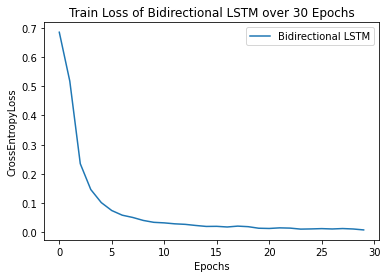

In [23]:
plt.xlabel("Epochs")
plt.ylabel("CrossEntropyLoss")
plt.title("Train Loss of Bidirectional LSTM over 30 Epochs")
plt.plot(train_loss_history, label="Bidirectional LSTM")
plt.legend()
plt.savefig("../report/figs/loss.pdf", format="pdf")
plt.show()